# My Content - Recommender System

## Téléchargement et Prétraitement des Données

Dans ce notebook, nous allons télécharger les fichiers de données et les prétraiter pour le système de recommandation.

In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import os
import requests

import tensorflow as tf

import mlflow
import mlflow.sklearn

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


## Téléchargement des fichiers de données

Nous allons télécharger les fichiers de données depuis les liens fournis et les enregistrer dans le répertoire `../data`.

In [4]:
import requests
import zipfile
import os

# Fonction pour télécharger un fichier
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vérifie si la requête a réussi
            with open(dest_path, 'wb') as file:
                file.write(response.content)
            print(f'Téléchargement terminé : {dest_path}')
        except requests.exceptions.RequestException as e:
            print(f'Erreur lors du téléchargement : {e}')
    else:
        print(f'Le fichier {dest_path} existe déjà. Téléchargement non nécessaire.')

# URL du fichier zip contenant les données
data_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip'

# Chemin de destination pour le fichier zip
zip_file_path = '../data/news-portal-user-interactions-by-globocom.zip'

# Création du répertoire data s'il n'existe pas
if not os.path.exists('../data'):
    os.makedirs('../data', exist_ok=True)
    print('Répertoire ../data créé.')

# Téléchargement du fichier zip
download_file(data_url, zip_file_path)

# Décompression du fichier zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('../data')
    print('Extraction terminée.')
except zipfile.BadZipFile:
    print('Erreur : Le fichier zip est corrompu.')

# Chemins des fichiers extraits
clicks_zip_path = '../data/clicks.zip'
clicks_sample_path = '../data/clicks_sample.csv'
articles_metadata_path = '../data/articles_metadata.csv'
articles_embeddings_path = '../data/articles_embeddings.pickle'

# Vérification des fichiers extraits
if all(os.path.exists(path) for path in [clicks_zip_path, clicks_sample_path, articles_metadata_path, articles_embeddings_path]):
    print(f'Fichiers extraits:\n- {clicks_zip_path}\n- {clicks_sample_path}\n- {articles_metadata_path}\n- {articles_embeddings_path}')
else:
    print('Erreur lors de l\'extraction des fichiers.')

# Décompression de clicks.zip
if os.path.exists(clicks_zip_path):
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall('../data')
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')

# Chemin des fichiers extraits de clicks.zip
clicks_path = '../data/clicks.zip'

# Décompression de clicks.zip
clicks_extract_dir = '../data/clicks/'
if not os.path.exists(clicks_extract_dir):
    os.makedirs(clicks_extract_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall(clicks_extract_dir)
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')
else:
    print(f'Le répertoire {clicks_extract_dir} existe déjà. Extraction non nécessaire.')



Le fichier ../data/news-portal-user-interactions-by-globocom.zip existe déjà. Téléchargement non nécessaire.
Extraction terminée.
Fichiers extraits:
- ../data/clicks.zip
- ../data/clicks_sample.csv
- ../data/articles_metadata.csv
- ../data/articles_embeddings.pickle
Extraction de clicks.zip terminée.
Le répertoire ../data/clicks/ existe déjà. Extraction non nécessaire.


## Chargement et aperçu des données

Nous allons maintenant charger les fichiers CSV et afficher un aperçu des données.

In [5]:
import pickle

# Lecture des fichiers CSV extraits de clicks.zip
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Lecture des autres fichiers
clicks_sample_df = pd.read_csv(clicks_sample_path)
articles_metadata_df = pd.read_csv(articles_metadata_path)

# Lecture du fichier pickle
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

# Aperçu des autres fichiers
print("Aperçu du fichier clicks_sample.csv:")
print(clicks_sample_df.head(), "\n")

print("Informations sur le fichier clicks_sample.csv:")
print(clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(articles_metadata_df.head(), "\n")

print("Informations sur le fichier articles_metadata.csv:")
print(articles_metadata_df.info(), "\n")

print("Aperçu des embeddings d'articles:")
print(f"Nombre d'articles : {len(articles_embeddings)}")
print(f"Exemple d'embedding pour le premier article : {articles_embeddings[0]}")

Aperçu du fichier clicks_sample.csv:
   user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   
3    1506827047951                  4                  1        17   
4    1506827090575                  4                  1        17   

   click_country  click_region  click_referrer_type  
0            

clicks_sample.csv :
Contient des données similaires aux fichiers extraits de clicks.zip.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_metadata.csv :
Contient des métadonnées sur les articles, comme le nombre de mots et autres caractéristiques.
Aperçu des 5 premières lignes et informations sur les colonnes et types de données.
articles_embeddings.pickle :
Contient les embeddings des articles (représentations vectorielles).
Nombre total d'articles : 364047
Exemple d'embedding pour le premier article : [0.08109499, 0.0563579, 0.21711417, ...]

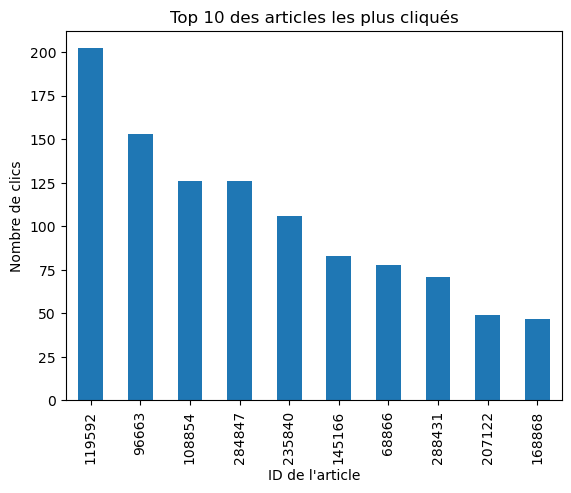

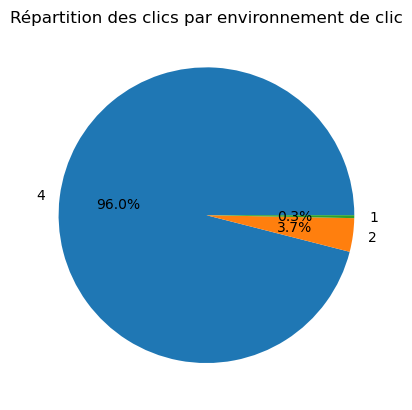

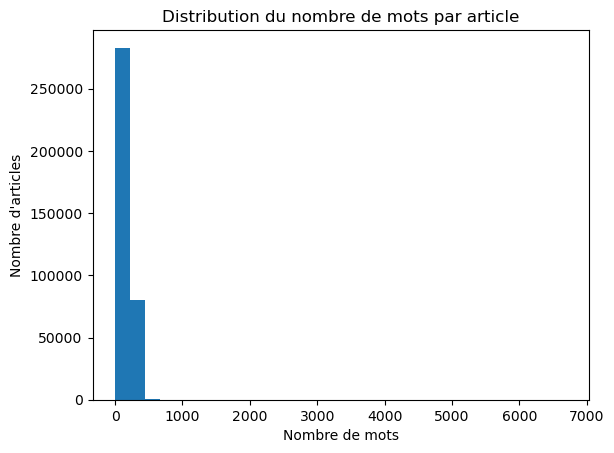

In [6]:
import matplotlib.pyplot as plt

# Distribution des clics par article dans clicks_sample.csv
clicks_sample_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par environnement de clic dans clicks_sample.csv
clicks_sample_df['click_environment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des clics par environnement de clic')
plt.ylabel('')
plt.show()

# Distribution du nombre de mots par article dans articles_metadata.csv
articles_metadata_df['words_count'].plot(kind='hist', bins=30)
plt.title('Distribution du nombre de mots par article')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre d\'articles')
plt.show()


## Prétraitement des données

Nous allons maintenant prétraiter les données pour le modèle de recommandation.
Filtrage collaboratif article-article basé sur les clics.
Calcul de la similarité cosinus entre les articles.

In [7]:
# Suivi des expériences avec MLflow
def log_model(model_name, model):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        # Vous pouvez ajouter des métriques spécifiques ici
        mlflow.sklearn.log_model(model, model_name)

# Fonction de recommandation basée sur la similarité article-article

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Préparation des données pour les modèles de recommandation
try:
    # Filtrage collaboratif article-article basé sur les clics
    article_user_matrix = clicks_sample_df.pivot_table(index='user_id', columns='click_article_id', values='session_id', aggfunc='count').fillna(0)
    
    # Vérifions la matrice utilisateur-article
    print("Aperçu de la matrice utilisateur-article:")
    print(article_user_matrix.head())

    # Convertir la matrice utilisateur-article en tenseur TensorFlow
    article_user_matrix_tensor = tf.convert_to_tensor(article_user_matrix.values, dtype=tf.float32)

    # Normaliser la matrice utilisateur-article
    normalized_article_user_matrix = tf.nn.l2_normalize(article_user_matrix_tensor, axis=0)

    # Calcul de la similarité cosinus entre les articles en utilisant TensorFlow
    article_similarity = tf.matmul(tf.transpose(normalized_article_user_matrix), normalized_article_user_matrix).numpy()
    
    # Vérifions la matrice de similarité
    print("Aperçu de la matrice de similarité:")
    print(article_similarity[:5, :5])  # Affichage d'un aperçu pour éviter trop de données

    # Fonction de recommandation basée sur la similarité article-article
    def recommend_articles_article_based(article_id, num_recommendations=5):
        article_idx = article_user_matrix.columns.get_loc(article_id)
        similar_articles = list(enumerate(article_similarity[article_idx]))
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
        recommended_articles = [article_user_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
        return recommended_articles

    # Exemple de recommandation d'articles pour un article donné
    article_id_example = article_user_matrix.columns[0]
    print(f"Recommandations pour l'article {article_id_example} : {recommend_articles_article_based(article_id_example)}")
    
except Exception as e:
    print(f"Une erreur s'est produite: {e}")


Aperçu de la matrice utilisateur-article:
click_article_id  2137    2662    4243    4658    7947    8844    10955   \
user_id                                                                    
0                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

click_article_id  13337   13540   14197   ...  352774  352809  353669  355863  \
user_id                                   ...                                   
0                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
1                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
2                    0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
3                   

2024-06-14 11:36:17.909246: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-14 11:36:17.909270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-14 11:36:17.909277: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-14 11:36:17.909310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-14 11:36:17.909321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Recommandation basée sur les métadonnées des articles (TF-IDF et similarité cosinus)

In [15]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Vérifiez si TensorFlow utilise le GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement des données
articles_metadata_df = pd.read_csv('../data/articles_metadata.csv')

# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
# Assurez-vous que n_components est inférieur ou égal au nombre de caractéristiques
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)  # Réduire à 100 dimensions ou moins
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Convertir la matrice TF-IDF réduite en tenseur TensorFlow
reduced_tfidf_matrix_tensor = tf.convert_to_tensor(reduced_tfidf_matrix, dtype=tf.float32)

# Normaliser la matrice TF-IDF
normalized_tfidf_matrix = tf.nn.l2_normalize(reduced_tfidf_matrix_tensor, axis=1)

# Fonction pour calculer la similarité cosinus en utilisant des lots
def batch_cosine_similarity(matrix, batch_size=1000):
    num_rows = matrix.shape[0]
    cosine_sim_matrix = np.zeros((num_rows, num_rows), dtype=np.float32)

    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)
        batch = matrix[start_idx:end_idx]
        similarity = tf.matmul(batch, matrix, transpose_b=True).numpy()
        cosine_sim_matrix[start_idx:end_idx] = similarity

    return cosine_sim_matrix

# Calcul de la similarité cosinus en utilisant des lots
cosine_sim = batch_cosine_similarity(normalized_tfidf_matrix, batch_size=1000)

# Vérifions la matrice de similarité
print("Aperçu de la matrice de similarité:")
print(cosine_sim[:5, :5])  # Affichage d'un aperçu pour éviter trop de données

# Fonction de recommandation basée sur le contenu
def recommend_articles_content_based(article_id, num_recommendations=5):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    similar_articles = list(enumerate(cosine_sim[article_idx]))
    similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
    recommended_articles = [articles_metadata_df['article_id'].iloc[i[0]] for i in similar_articles[1:num_recommendations+1]]
    return recommended_articles

# Exemple de recommandation d'articles basée sur le contenu pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur le contenu pour l'article {article_id_example} : {recommend_articles_content_based(article_id_example)}")


Num GPUs Available:  1


/opt/anaconda3/envs/TF_M2_last_version/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


: 

# Fonction de recommandation basée sur le contenu

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Vérifiez si TensorFlow utilise le GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement des données
articles_metadata_df = pd.read_csv('../data/articles_metadata.csv')

# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
# Assurez-vous que n_components est inférieur ou égal au nombre de caractéristiques
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)  # Réduire à 100 dimensions ou moins
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Convertir la matrice TF-IDF réduite en tenseur TensorFlow
reduced_tfidf_matrix_tensor = tf.convert_to_tensor(reduced_tfidf_matrix, dtype=tf.float32)

# Normaliser la matrice TF-IDF
normalized_tfidf_matrix = tf.nn.l2_normalize(reduced_tfidf_matrix_tensor, axis=1)

# Fonction pour calculer la similarité cosinus en utilisant des lots
def batch_cosine_similarity(matrix, batch_size=1000):
    num_rows = matrix.shape[0]
    cosine_sim_matrix = np.zeros((num_rows, num_rows), dtype=np.float32)

    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)
        batch = matrix[start_idx:end_idx]
        similarity = tf.matmul(batch, matrix, transpose_b=True).numpy()
        cosine_sim_matrix[start_idx:end_idx] = similarity

    return cosine_sim_matrix

# Calcul de la similarité cosinus en utilisant des lots
cosine_sim = batch_cosine_similarity(normalized_tfidf_matrix, batch_size=1000)

# Vérifions la matrice de similarité
print("Aperçu de la matrice de similarité:")
print(cosine_sim[:5, :5])  # Affichage d'un aperçu pour éviter trop de données

# Fonction de recommandation basée sur le contenu avec gestion par lots
def recommend_articles_content_based(article_id, num_recommendations=5, batch_size=1000):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    num_articles = cosine_sim.shape[0]

    # Calcul de la similarité par lots
    similar_articles = []
    for start_idx in range(0, num_articles, batch_size):
        end_idx = min(start_idx + batch_size, num_articles)
        batch_similarities = cosine_sim[article_idx, start_idx:end_idx]
        batch_indices = range(start_idx, end_idx)
        similar_articles.extend(zip(batch_indices, batch_similarities))

    similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
    recommended_articles = [articles_metadata_df['article_id'].iloc[i[0]] for i in similar_articles[1:num_recommendations+1]]
    return recommended_articles

# Exemple de recommandation d'articles basée sur le contenu pour un article donné
article_id_example = articles_metadata_df['article_id'].iloc[0]
print(f"Recommandations basées sur le contenu pour l'article {article_id_example} : {recommend_articles_content_based(article_id_example)}")


# Recommandation hybride combinant filtrage collaboratif et basé sur le contenu

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Vérifiez si TensorFlow utilise le GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement des données
articles_metadata_df = pd.read_csv('../data/articles_metadata.csv')
clicks_sample_df = pd.read_csv('../data/clicks_sample.csv')

# Préparation des données pour le filtrage collaboratif
article_user_matrix = clicks_sample_df.pivot_table(index='user_id', columns='click_article_id', values='session_id', aggfunc='count').fillna(0)

# Calcul de la similarité cosinus pour le filtrage collaboratif
article_similarity = cosine_similarity(article_user_matrix.T)

# Fonction de recommandation basée sur le filtrage collaboratif
def recommend_articles_article_based(article_id, num_recommendations=5):
    article_idx = article_user_matrix.columns.get_loc(article_id)
    similar_articles = list(enumerate(article_similarity[article_idx]))
    similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
    recommended_articles = [article_user_matrix.columns[i[0]] for i in similar_articles[1:num_recommendations+1]]
    return recommended_articles

# Ajouter des colonnes fictives 'title' et 'content' pour la démonstration
articles_metadata_df['title'] = ["Example Title"] * len(articles_metadata_df)
articles_metadata_df['content'] = ["Example Content"] * len(articles_metadata_df)

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_metadata_df['title'] + " " + articles_metadata_df['content'])

# Réduction de dimensions avec TruncatedSVD
n_components = min(100, tfidf_matrix.shape[1])
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

# Convertir la matrice TF-IDF réduite en tenseur TensorFlow
reduced_tfidf_matrix_tensor = tf.convert_to_tensor(reduced_tfidf_matrix, dtype=tf.float32)

# Normaliser la matrice TF-IDF
normalized_tfidf_matrix = tf.nn.l2_normalize(reduced_tfidf_matrix_tensor, axis=1)

# Fonction pour calculer la similarité cosinus en utilisant des lots
def batch_cosine_similarity(matrix, batch_size=1000):
    num_rows = matrix.shape[0]
    cosine_sim_matrix = np.zeros((num_rows, num_rows), dtype=np.float32)

    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)
        batch = matrix[start_idx:end_idx]
        similarity = tf.matmul(batch, matrix, transpose_b=True).numpy()
        cosine_sim_matrix[start_idx:end_idx] = similarity

    return cosine_sim_matrix

# Calcul de la similarité cosinus en utilisant des lots
cosine_sim = batch_cosine_similarity(normalized_tfidf_matrix, batch_size=1000)

# Fonction de recommandation basée sur le contenu
def recommend_articles_content_based(article_id, num_recommendations=5):
    article_idx = articles_metadata_df[articles_metadata_df['article_id'] == article_id].index[0]
    similar_articles = list(enumerate(cosine_sim[article_idx]))
    similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)
    recommended_articles = [articles_metadata_df['article_id'].iloc[i[0]] for i in similar_articles[1:num_recommendations+1]]
    return recommended_articles

# Recommandation hybride combinant filtrage collaboratif et basé sur le contenu
def hybrid_recommendation(user_id, num_recommendations=5):
    # Recommandations basées sur le filtrage collaboratif
    user_clicks = article_user_matrix.loc[user_id]
    user_clicks = user_clicks[user_clicks > 0]
    collaborative_recommendations = []
    for article_id in user_clicks.index:
        collaborative_recommendations.extend(recommend_articles_article_based(article_id, num_recommendations))
    collaborative_recommendations = list(set(collaborative_recommendations))
    
    # Recommandations basées sur le contenu
    content_based_recommendations = []
    for article_id in user_clicks.index:
        content_based_recommendations.extend(recommend_articles_content_based(article_id, num_recommendations))
    content_based_recommendations = list(set(content_based_recommendations))
    
    # Combiner les recommandations
    combined_recommendations = list(set(collaborative_recommendations + content_based_recommendations))
    return combined_recommendations[:num_recommendations]

# Exemple de recommandation hybride pour un utilisateur donné
user_id_example = article_user_matrix.index[0]
print(f"Recommandations hybrides pour l'utilisateur {user_id_example} : {hybrid_recommendation(user_id_example)}")


## Sauvegarde des données prétraitées

Nous allons sauvegarder les données prétraitées pour une utilisation ultérieure dans l'entraînement du modèle.

In [ ]:
# Sauvegarde du modèle et des données préparées
import joblib

# Enregistrer et suivre les modèles
log_model("Filtrage Collaboratif Article-Article", article_similarity)
log_model("TF-IDF Vectorizer", tfidf_vectorizer)
log_model("TF-IDF Matrix", tfidf_matrix)
log_model("Similarité Cosinus", cosine_sim)

joblib.dump(article_user_matrix, 'article_user_matrix.pkl')
joblib.dump(article_similarity, 'article_similarity.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
joblib.dump(cosine_sim, 'cosine_sim.pkl')

print("Modèles et données préparées sauvegardés.")

In [1]:
%pip install  fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=f4ceb67940b5c96dfd3dd1a289a009032bf7747ad62b1cc002b83da3f0bcdc66
  Stored in directory: /Users/cyrilleguillaud/Library/Caches/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fpdf import FPDF
import os

# Classe PDF personnalisée
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Organisation du site', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_chapter(self, title, body):
        self.add_page()
        self.chapter_title(title)
        self.chapter_body(body)

# Fonction pour générer l'arborescence sans extensions
def generate_tree(path, level=0):
    tree = ""
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            tree += "  " * level + "- " + os.path.splitext(item)[0] + "\n"
            tree += generate_tree(item_path, level + 1)
        else:
            tree += "  " * level + "- " + os.path.splitext(item)[0] + "\n"
    return tree

# Chemin du répertoire à analyser
base_path = "/Users/cyrilleguillaud/Downloads/site"

# Générer l'arborescence
tree_structure = generate_tree(base_path)

# Créer le PDF
pdf = PDF()
pdf.set_left_margin(10)
pdf.set_right_margin(10)
pdf.add_chapter("Arborescence du site", tree_structure)

# Sauvegarder le PDF
pdf.output("organisation_site.pdf")

print("PDF généré avec succès : organisation_site.pdf")

PDF généré avec succès : organisation_site.pdf
